# Classifying Melanoma

v2.3.8

Author: Tim Chen (chentim@berkeley.edu)  
Keywords: Convolutional Neural Network, Logistic Regression (LR), Support Vector Machine (SVM), Principle Component Analysis (PCA), EfficientNet, Focal Loss, K-fold Cross Validation, Keras, TensorFlow

(Please refer to model_v3.ipynb for the formal writeup.)

## Environment Setup

### Installs & Imports

In [ ]:
# install libraries not on colab
%pip install -U --pre efficientnet

In [ ]:
import os
import sys
import warnings
import logging
import random
import re
import math

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import matplotlib.patches as patches
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import tensorflow as tf
import tensorflow.keras as keras
import efficientnet.tfkeras as efn

from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall
from tensorflow.keras import backend as K
from tensorflow.train import Feature, Features, Example
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, GlobalAveragePooling2D, InputLayer
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import applications
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential

from itertools import tee
from IPython.display import display, HTML, Javascript
from datetime import datetime
from IPython.display import display 
from io import BytesIO
from PIL import Image
from skimage import io
from typing import List, Tuple

from google.colab import drive
from google.colab import auth
import google.colab as co
import uuid

%matplotlib inline


IS_LOCAL = False # local vs. colab
USE_GCS = False # set true to use my personal GCS instead of Kaggle's GCS

if IS_LOCAL:
    # jupyter offline
    KAGGLE_MEL_DIR = './../kaggle_symlink_offline/melanoma/'
    JPEG_RAW_TRAIN_DIR = KAGGLE_MEL_DIR + 'jpeg/train/'
    REPO_ROOT = './../../'
    TFREC_DIR = REPO_ROOT + '/kaggle_symlink_offline/melanoma/tfrecords/triple_stra_{}/'
else:
    if USE_GCS:
        # auth GCS storage
        GCS_PROJECT_ID = 'yinky'
        GCS_BUCKET_NAME = 'yintrigue_us_west_oregon'
        auth.authenticate_user()

        TFREC_GCS = {
            128: 'gs://yintrigue_us_west_oregon/melanoma/tfrecords/triple_stra_128',
            256: 'gs://yintrigue_us_west_oregon/melanoma/tfrecords/triple_stra_256'}
    else:
        # http://tiny.cc/8jjjsz
        # loading from Kaggle to save $$$ (vs. loading from my own GCS)
        TFREC_GCS = {128: 'gs://kds-56c85f3fb285c7997b2b40a34d8d3a28a2348744246ba8f94d7aa621',
                     192: 'gs://kds-c68fb3b4435e216f4b7a62405fd83b44ea4e88d81fc7812220f3a55e',
                     256: 'gs://kds-dffc4fc041639d63f5cb739622149422dbd485d2bd7f66a514c67fae',
                     384: 'gs://kds-30a0c9f78d3675d10f6b6546877a20d24100810cef730172979b36af',
                     512: 'gs://kds-df537acf009e02b1d4427274d18970a1b0101b1ca26824bae39b5b4b',
                     768: 'gs://kds-79662e42fc05f15bf1149504a028b04213a0218d96b9180368ce47a5'}

    # colab online
    KAGGLE_MEL_DIR = '/content/gdrive/My Drive/Kaggle/melanoma/'
    JPEG_RAW_TRAIN_DIR = KAGGLE_MEL_DIR + 'jpeg/train/'
    REPO_ROOT = '/content/gdrive/My Drive/melanoma/'
    
    # mount google drive only on colab
    drive.mount('/content/gdrive')
    display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

# additional setups
warnings.filterwarnings("ignore") # suppress warning messages
plt.style.use(u"ggplot") # custom plot style

### CNN Configurations

In [ ]:
if IS_LOCAL: # configr optimize for efficiency due to limited computing power
    # option: TPU, GPU (default to CPU if the specified processor is not found)
    PROCESSOR = "GPU" 

    FOLDS = 2 # option: 3, 5, 15 
    TFREC_SPLITS = 2 # count of tfrec files, hardcoded just for convenience

    # https://tinyurl.com/yao4obsb
    # A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
    # Therefore, for efficient utilization of Cloud TPU, a program should make use of 
    # each of the eight cores.
    #
    # https://tinyurl.com/y99kjyh5
    # Model processing performance
    # For optimum memory usage, use the largest batch size that will fit in memory. 
    # Each TPU core uses a 128 x 128 memory cell matrix for processing. In general, 
    # your batch sized should be evenly divisible by 128 to most effectively use the TPU memory.
    #
    # https://tinyurl.com/yawn2acn
    # Batch Size Too Small
    # The batch size of any model should always be at least 64 (8 per TPU core) 
    # because TPU always pads the tensors to this size. The ideal batch size when 
    # training on the TPU is 1024 (128 per TPU core), since this eliminates inefficiencies 
    # related to memory transfer and padding.
    #
    # https://tinyurl.com/y9nojpa2
    # Minimal requirement: A multiple of 8!
    BATCH_SIZES = [32] * FOLDS 
    EPOCHS = [10] * FOLDS

    # 0: BinaryCrossentropy
    # 1: FocalLoss
    LOSS_FUNCTIONS = [0, 0] 
    LOSS_FUNC_NAMES = ['Binary Crossentropy', 'Focal Loss']
    FL_GAMMA = 2.0
    FL_ALPHA = 0.75
    LEARNING_RATE = 0.001

    EFF_NETS = [0, 4]
    # 128, 192, 256, 384, 512, 768, 1024
    IMG_SIZES = [128, 128]

    TFREC_TRAIN_SETS = [None] * FOLDS
    for i, dim in enumerate(IMG_SIZES):
        TFREC_TRAIN_SETS[i] = tf.io.gfile.glob(TFREC_DIR.format(dim) + 'train*.tfrec')

    # Images used for validation should be subject to the same random augmentation
    # mechanism if input images are randomly augmented. TTA specifies the number of 
    # times each validation image will be randomly augmented and predicted. A final
    # predicted probability is then calculated by averaging.
    TTA_STEPS = 1 # TEST TIME AUGMENTATION STEPS
    RANDOM_AUG = False

    # set true to load the weights from "epoch with the best performance" at the 
    # end of training
    BEST_MODEL = True
    # all models predicts probabilities instead of labels; this threshold is 
    # used only for reporting
    SIGMOID_THD = 0.2

else: # configr optimize for performance
    PROCESSOR = "TPU" 

    FOLDS = 5
    TFREC_SPLITS = 15
    
    # dim 512 and bs 128 is the limit of TPU on Colab
    BATCH_SIZES = [64] * FOLDS 
    EPOCHS = [10] * FOLDS

    # 0: BinaryCrossentropy
    # 1: FocalLoss
    LOSS_FUNCTIONS = [0, 1, 0, 1, 0]
    LOSS_FUNC_NAMES = ['Binary Crossentropy', 'Focal Loss']
    FL_GAMMA = 2.0
    FL_ALPHA = 0.75
    LEARNING_RATE = 0.001

    EFF_NETS = [7, 7, 4, 4, 0]
    IMG_SIZES = [256, 256, 256, 256, 256]

    TFREC_TRAIN_SETS = [None] * FOLDS
    for i, dim in enumerate(IMG_SIZES):
        TFREC_TRAIN_SETS[i] = tf.io.gfile.glob(TFREC_GCS[dim] + '/train*.tfrec')

    TTA_STEPS = 10
    RANDOM_AUG = True

    BEST_MODEL = True
    SIGMOID_THD = 0.2


SEED = 207 # used for creating k-fold

### Initializing TPU

In [ ]:
if PROCESSOR == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU: ', tpu.master())
    except ValueError:
        print("Error: Unable to connect to TPU...")
        tpu = None

    if tpu:
        try:
            print("Initializing TPU...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized!")
        except _:
            print("Error: Failed to initialize TPU...")
    else:
        PROCESSOR = "GPU"

if PROCESSOR != "TPU":
    print("Using default strategy for CPU/GPU...")
    strategy = tf.distribute.get_strategy()

if PROCESSOR == "GPU":
    print("# of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
            
# https://tinyurl.com/yao4obsb
# A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
# Therefore, for efficient utilization of Cloud TPU, a program should make use of 
# each of the eight cores.
REPLICAS = strategy.num_replicas_in_sync
print(f'# of replicatas in sync: {REPLICAS}')

### CNN Utility Classes & Functions

In [ ]:
class TFRECParser:
    """Class to parse the TFRecord files that come with the original dataset.
    """
    __TFREC_DESCRIPTOR = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    } 

    def __init__(self) -> None:
        self.__dataset = None # tf.data.TFRecordDataset

    @tf.autograph.experimental.do_not_convert
    def load(self, path_tfrec: str = 'tfrecords/train*.tfrec') -> None:
        def parser(serialized_example: Example) -> Example:
            example = tf.io.parse_single_example(serialized_example,
                                                 features=TFRECParser.__TFREC_DESCRIPTOR)
            return example
        self.__dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(path_tfrec))
        self.__dataset = self.__dataset.map(parser)

    def get_dataset(self) -> tf.data.Dataset:
        return self.__dataset

    def get_image_arr(self, image_name: str) -> np.ndarray:
        record_dataset = self.__dataset.filter(lambda example: tf.equal(example["image_name"], image_name))
        example = next(iter(record_dataset))
        arr = tf.image.decode_jpeg(example['image'], channels=3).numpy()
        return arr

    def get_image(self, image_name: str) -> Image:
        return Image.fromarray(self.get_image_arr(image_name))

    def plot_image(self, image_name: str, 
                   figsize: list = [5, 5], 
                   ax: plt.axes = None,
                   show_info: bool = False) -> Image:
        img_arr = self.get_image_arr(image_name)
        img = Image.fromarray(img_arr)

        # prep title
        if show_info:
            title = "{}, {}x{}, {:.2f}MB".format(image_name,
                                                img.size[0],
                                                img.size[1],
                                                sys.getsizeof(img_arr)/1024/1024)
        else:
            title = image_name

         # render plot
        if ax is None:
            plt.figure(figsize=figsize)
            io.imshow(img_arr)
            plt.title(title)
            plt.show()
        else:
            ax.imshow(img_arr)
            ax.set_title(title)
    
    def plot_images(self, img_names: list, title: str = None) -> None:
        if len(img_names) == 1:
            self.plot_image(img_names[0])
            return

        PLOT_COL_COUNT = 7

        img_names = img_names.copy()

        n = len(img_names)
        row_count = n // PLOT_COL_COUNT
        if n % PLOT_COL_COUNT != 0 or row_count == 0:
            row_count += 1

        if row_count > 1:
            fig, axes = plt.subplots(row_count, 
                                     PLOT_COL_COUNT,
                                     figsize=(PLOT_COL_COUNT*3, row_count*3))
            if title is not None:
                fig.suptitle(title, fontsize=16)
                
            for row in axes:
                for ax in row:
                    # style
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)

                    # render
                    if len(img_names) > 0:
                        self.plot_image(img_names.pop(), ax=ax)
        else:
             fig, axes = plt.subplots(1, n, figsize=(n*4, 4))
             if title is not None:
                 fig.suptitle(title, fontsize=16)

             for ax in axes:
                 # style
                 ax.get_xaxis().set_visible(False)
                 ax.get_yaxis().set_visible(False)

                 # render
                 self.plot_image(img_names.pop(), ax=ax)

def read_labeled_tfrecord(example: Example) -> Tuple['tf.string', 'tf.int64']:
    """Extract image & label from the tfrecord.
    """
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example: Example, 
                            return_img_name: bool) -> Tuple['tf.string', 'tf.int64']:
    """Label is unavailable, extract image & image name from the tfrecord.
    """
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    if return_img_name:
        return example['image'], example['image_name']
    else:
        return example['image'], 0

def aug_image(img, augment=True, dim=256):
    """Apply random transformation.
    """
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_flip_up_down(img)
        img = tf.clip_by_value(img, 0.0, 1.0)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_examples(file_names: List[str]):
    """Note that the name of each tfrecord file is sufixed with the number of 
    images included.
    """
    n = [int(re.compile(r"-([0-9]*)\.").search(f).group(1)) 
         for f in file_names]
    return np.sum(n)
                  
def get_dataset(tfrec_files: List[str], 
                dim: int,
                batch_size: int = 64,
                augment: bool = False, 
                shuffle: bool = False, 
                repeat: bool = False, 
                labeled: bool = True, 
                return_img_names: bool = True,
                drop_remainder: bool = False,
                replicas: int = strategy.num_replicas_in_sync) -> Tuple[tf.data.TFRecordDataset, int]:
    """Return a TFRecordDataset by loading tfrecord files.
    Args:
        tfrec_files (List[str]): List of paths to the tfrecord files.
    Returns:
        [0](TFRecordDataset): Two possible column combinations... 
            - 'image' & 'target' for training dataset
            - 'image' & 'image_name' for test dataset
        [1](int): Number of steps to complete an epoch.
    """
    
    AUTO = tf.data.experimental.AUTOTUNE
    ds = tf.data.TFRecordDataset(tfrec_files, 
                                 num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if not repeat:
        ds = ds.repeat(1)
    else:
        ds = ds.repeat(-1)

    if shuffle: 
        ds = ds.shuffle(buffer_size=1024) # 1024 to optimize TPU performance
        opt = tf.data.Options()
        opt.experimental_deterministic = False # ensure a true random shuffle
        ds = ds.with_options(opt)
    
    if labeled: 
        # extract image & label
        # ds inlcudes just one column of examples
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        # extract image & image name
        # ds inlcudes just one column of examples
        map_ = lambda example: read_unlabeled_tfrecord(example, return_img_names)
        ds = ds.map(map_, num_parallel_calls=AUTO)      
    
    # transform image
    # ds has two columns: "image (intf.string)" and "label or image name"
    map_ = lambda img, _: (aug_image(img, augment=augment, dim=dim), _)
    ds = ds.map(map_, num_parallel_calls=AUTO)
    
    # https://tinyurl.com/yao4obsb
    # A single Cloud TPU device consists of four chips, each of which has two TPU cores. 
    # Therefore, for efficient utilization of Cloud TPU, a program should make use of 
    # each of the eight cores.
    #
    # https://tinyurl.com/y99kjyh5
    # Model processing performance
    # For optimum memory usage, use the largest batch size that will fit in memory. 
    # Each TPU core uses a 128 x 128 memory cell matrix for processing. In general, 
    # your batch sized should be evenly divisible by 128 to most effectively use the TPU memory.
    #
    # https://tinyurl.com/yawn2acn
    # Batch Size Too Small
    # The batch size of any model should always be at least 64 (8 per TPU core) 
    # because TPU always pads the tensors to this size. The ideal batch size when 
    # training on the TPU is 1024 (128 per TPU core), since this eliminates inefficiencies 
    # related to memory transfer and padding.
    #
    # https://tinyurl.com/y9nojpa2
    # Minimal requirement: A multiple of 8!
    if PROCESSOR == 'TPU':
        if batch_size < 64:
            # better
            print('Warning: Batch size {} is smaller than 64...'.format(batch_size))
        if batch_size % 8 > 0:
            # min requirement
            print('Error: Batch size {} is not a multiple of 8...'.format(batch_size))
    ds = ds.batch(batch_size, drop_remainder=drop_remainder) 
    
    num_images = count_examples(tfrec_files)
    steps = num_images // batch_size
    if num_images % batch_size > 0:
        # require one more step to loop through the entire dataset
        steps += 1
    
    # From tf doc (https://tinyurl.com/yavczqkr):
    # Most dataset input pipelines should end with a call to prefetch. This allows 
    # later elements to be prepared while the current element is being processed. This 
    # often improves latency and throughput, at the cost of using additional memory to 
    # store prefetched elements.
    ds = ds.prefetch(AUTO)
    
    return ds, steps

def focal_loss(gamma: float = 2., alpha: float = .25) -> callable:
    """Soruces:
            https://tinyurl.com/y4e66a44
            https://tinyurl.com/yyudyorg
    """
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

def build_efns(dim: int, 
               ef: int, 
               loss: int = 0,
               sig_thd: float = SIGMOID_THD,
               fl_gamma: float = FL_GAMMA,
               fl_alpha: float = FL_ALPHA,
               lr: float = LEARNING_RATE) -> Sequential:

    EFNS = [efn.EfficientNetB0, 
            efn.EfficientNetB1, 
            efn.EfficientNetB2, 
            efn.EfficientNetB3, 
            efn.EfficientNetB4, 
            efn.EfficientNetB5, 
            efn.EfficientNetB6,
            efn.EfficientNetB7]
    LOSS_FS = [keras.losses.BinaryCrossentropy(label_smoothing=0.05),
               focal_loss(fl_gamma, fl_alpha)]
    
    m = Sequential()
    base = EFNS[ef](weights="imagenet", 
                    include_top=False, 
                    input_shape=(dim, dim, 3))
    m.add(base)
    m.add(GlobalAveragePooling2D())
    m.add(Dense(1, activation="sigmoid"))
    
    # compile model
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), 
              loss=LOSS_FS[loss], 
              metrics=[AUC(),
                       BinaryAccuracy(threshold=sig_thd),
                       Recall(thresholds=sig_thd)])

    return m

## EDA:  Training Images & Metadata Analysis

### Issue: Duplicate Entries
Competition host has issued a [warning on duplicated images](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/161943). These images will be removed from the dataset prior to training. 

### Issue: Missing Entries
There are a total out of 33,126 examples included in the training dataset. The training CSV is not perfectly clean, with 595 examples that come with at least one null feature. 

However, all examples come with `image_name` and `target`, and most of the null entries look to be in the column, `anatom_site_general_challenge`. Overall, the dataset is ready for training a CNN (Convolutional Neural Network), assuming that all images specified in the CSV can be loaded properly. The only caveat is the missing values in the other categorial variables (`sex`, `age_approx`, `anatom_site_general_challenge`, and `diagnosis`) if contextual information is included for modeling.



In [ ]:
TRAIN_CSV_PATH = KAGGLE_MEL_DIR + 'csv/train.csv'
train_df = pd.read_csv(TRAIN_CSV_PATH)
train_positive_df = train_df.loc[train_df.target == 1, :]

print('Total number of training examples: {:,}'.format(train_df.shape[0]))

isnull_by_row = train_df.isnull().any(1)
print(f'# of examples with at least one null value: {isnull_by_row.values.sum()}')
print(f'# of positive examples with at least one null value: {train_positive_df.isnull().any(1).sum()}')
print('# of null "image_name": {}'.format(train_df.loc[:, 'image_name'].isnull().sum()))
print('# of null "target": {}'.format(train_df.loc[:, 'target'].isnull().sum()))
print('# of null "sex": {}'.format(train_df.loc[:, 'sex'].isnull().sum()))
print('# of null "age": {}'.format(train_df.loc[:, 'age_approx'].isnull().sum()))
print('# of null "anatom_site_general_challenge": {}'.format(train_df.loc[:, 'anatom_site_general_challenge'].isnull().sum()))
print('\nExamples with at least one null feature:')
train_df.iloc[isnull_by_row.tolist(), :]

Total number of training examples: 33,126
# of examples with at least one null value: 595
# of positive examples with at least one null value: 9
# of null "image_name": 0
# of null "target": 0
# of null "sex": 65
# of null "age": 68
# of null "anatom_site_general_challenge": 527

Examples with at least one null feature:


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
33,ISIC_0086462,IP_3200260,female,30.0,NaN,unknown,benign,0
38,ISIC_0088137,IP_5205991,NaN,NaN,lower extremity,unknown,benign,0
61,ISIC_0099474,IP_3057277,male,45.0,NaN,unknown,benign,0
188,ISIC_0174903,IP_2760044,male,40.0,NaN,unknown,benign,0
200,ISIC_0178744,IP_4248414,male,25.0,NaN,unknown,benign,0
...,...,...,...,...,...,...,...,...
32898,ISIC_9928421,IP_0961415,male,45.0,NaN,unknown,benign,0
33001,ISIC_9963692,IP_6017204,female,35.0,NaN,unknown,benign,0
33025,ISIC_9971473,IP_1005683,male,70.0,NaN,unknown,benign,0
33041,ISIC_9975949,IP_9245079,male,40.0,NaN,nevus,benign,0


### Issue: Class Imbalance

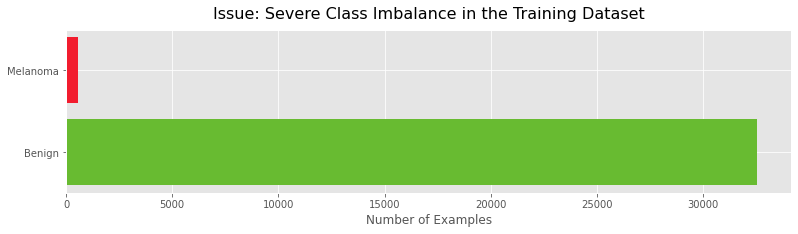

In [ ]:
count_pos = train_df.loc[train_df.target == 1, :].shape[0]
count_neg = train_df.loc[train_df.target == 0, :].shape[0]

fig, ax = plt.subplots(figsize=(13, 3))

ax.barh(['Benign', 'Melanoma'], 
        [count_neg, count_pos], 
        color=['#68bb31', '#f21c2e'])
ax.set_xlabel("Number of Examples")
ax.set_title("Issue: Severe Class Imbalance in the Training Dataset",
             pad=11, 
             fontsize=16)

plt.show()

### Issue: Input Image Inconsistency
A number of challenges can be identified by randomly examining a few Melanoma and Benign images.
- **Crops**: A number of images have irregular shape such as circular crops.
- **Hair**: Some images come with lots of hair covering the skin.
- **Unexpected Objects**: Some images come rulers and purple marks. If could be an issue if the objects correlate the occurrence of positive or negative examples.
- **Ratios & Resolutions**: Images come with different ratios and resolutions.
- **Image Quality**: Most images come with different brightness, white balance, temperature, etc.
- **File Size**: There are a total of 33,000+ JPEGs (40GB+)in the raw training set. Feature engineering such as downsampling might be requried to improve the training efficiency.


<IPython.core.display.Javascript object>

Random Positive Examples (Melanoma):


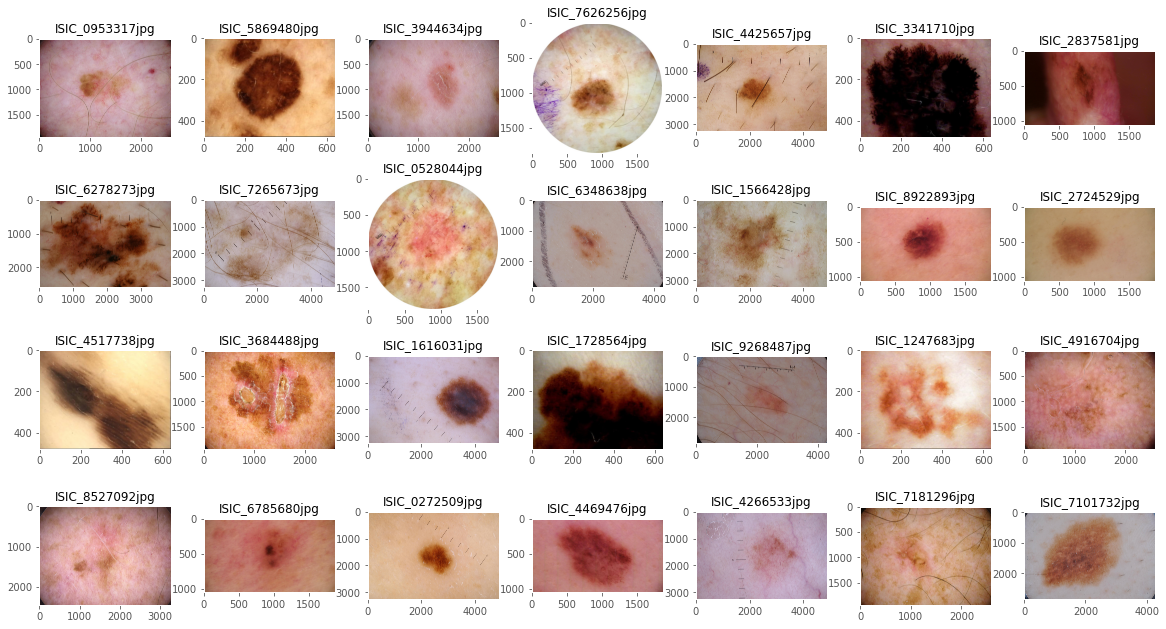


Random Negative Examples (Benign):


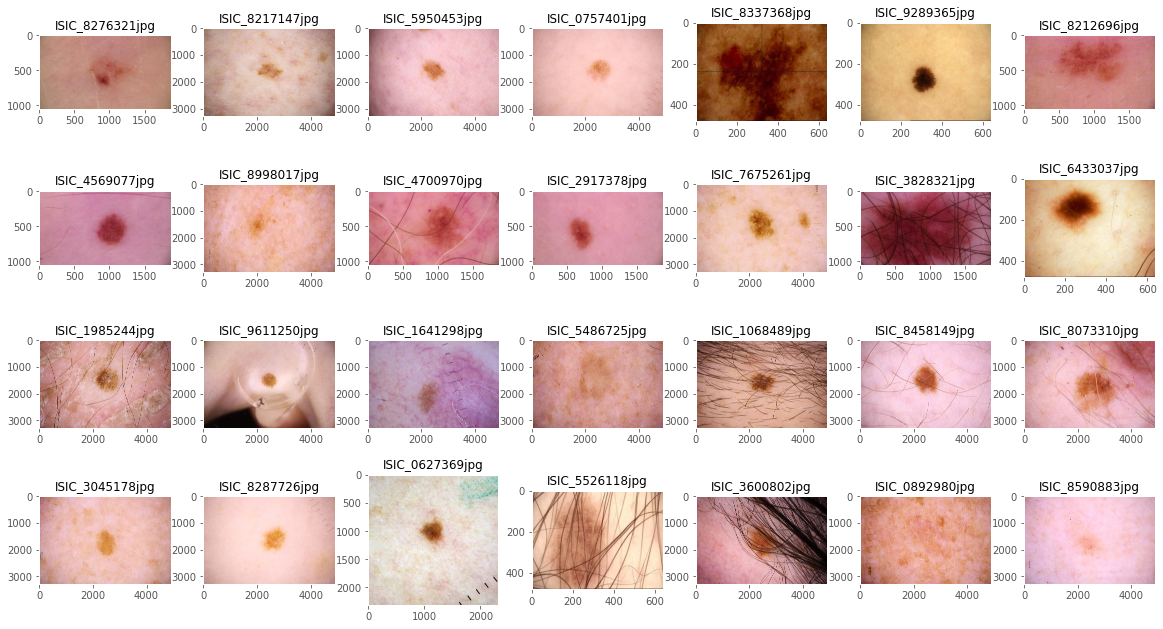

In [ ]:
# prevent auto_scrolling
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

# pull df
pos_df = train_df.loc[train_df.target == 1, :]
neg_df = train_df.loc[train_df.target == 0, :]
pos_df = pos_df.sample(frac=1).reset_index(drop=True)
neg_df = neg_df.sample(frac=1).reset_index(drop=True)

# plot positive examples
fig, axes = plt.subplots(4, 7, figsize=(20, 11))
fig.subplots_adjust(wspace=.25)
i = 0
print('Random Positive Examples (Melanoma):')
for row in axes:
    for ax in row:
        img_name = pos_df['image_name'][i]
        img = Image.open(JPEG_RAW_TRAIN_DIR + img_name + '.jpg')
        ax.imshow(img)
        ax.grid(False)
        ax.set_title(img_name + 'jpg', fontsize=12)
        i += 1
plt.show()

# plot negative examples
fig, axes = plt.subplots(4, 7, figsize=(20, 11))
fig.subplots_adjust(wspace=.25 )
i = 0
print('\nRandom Negative Examples (Benign):')
for row in axes:
    for ax in row:
        img_name = neg_df['image_name'][i]
        img = Image.open(JPEG_RAW_TRAIN_DIR + img_name + '.jpg')
        ax.imshow(img)
        ax.grid(False)
        ax.set_title(img_name + 'jpg', fontsize=12)
        i += 1
plt.show()

### Metadata Exploratory
While the project primarily focuses on modeling using the image set, the CSV does come with additional metadata that could help predictions. The analysis included in this section is not comprehensive but offers a high-level overview on thethe additional information available through metadata.

#### Age Distribution
There is a clear difference between the age distributions for Melanoma and Benign examples. The age distribution for Benign examples resembles a Gaussian distribution centering around age 45. The age distribution for Melanoma, on the other hand, is skewed towards older ages, peaking around 65 to 70. 

Conclusion: Age could be a strong signal for predicting Melanoma.

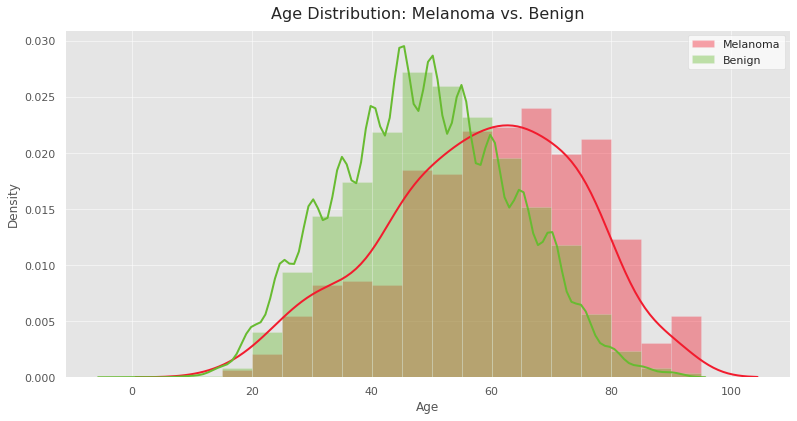

In [ ]:
# pull df
pos_df = train_df.loc[train_df.target == 1, :]
neg_df = train_df.loc[train_df.target == 0, :]
age_pos_df = pos_df.loc[:, 'age_approx']
age_neg_df = neg_df.loc[:, 'age_approx']

# plot
fig, ax = plt.subplots(figsize=(13, 6))
fig.subplots_adjust(top=0.93)
sns.distplot(age_pos_df, 
             kde=True,
             color='#f21c2e', 
             bins=list(range(0, 100, 5)),
             label='Melanoma')
sns.distplot(age_neg_df,
             kde=True, 
             color='#68bb31', 
             bins=list(range(0, 100, 5)),
             label='Benign')

ax.set_ylabel('Density')
ax.set_xlabel('Age')
ax.set_title('Age Distribution: Melanoma vs. Benign', fontsize=16, pad=11)

ax.legend(facecolor='white', 
          framealpha=0.7, 
          fancybox=True)
plt.show()
pass

#### Gender Comparison
There doesn't seem to be any observable difference between genders in terms of the probability of having Melanoma. Gender does not seem to be a good indicator to be included for modeling.

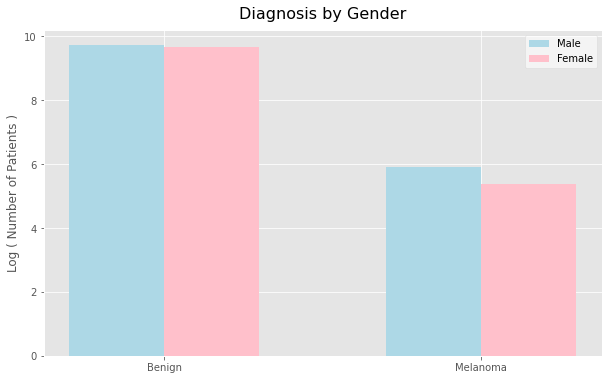

In [ ]:
# pull base df
df = train_df.loc[:, ['sex', 'benign_malignant']].dropna()
male_df = df.loc[df.sex=='male', :]
female_df = df.loc[df.sex=='female', :]

# seperate by positive vs. negative
male_df = male_df.groupby('benign_malignant').count()
female_df = female_df.groupby('benign_malignant').count()
display()


# "side-by-side" bat chart trick from:
# https://tinyurl.com/y5z6bxqe
N = 2
WIDTH = 0.3
male_bars = (np.log(male_df.loc['benign', 'sex']), 
             np.log(male_df.loc['malignant', 'sex']))
female_bars = (np.log(female_df.loc['benign', 'sex']), 
               np.log(female_df.loc['malignant', 'sex']))

ind = np.arange(N)
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ind, male_bars , WIDTH, label='Male', color='lightblue')
ax.bar(ind + WIDTH, female_bars, WIDTH, label='Female', color='pink')

ax.set_ylabel('Log ( Number of Patients )')
ax.set_title('Diagnosis by Gender', fontsize=16, pad=11)
ax.set_xticks(ind + WIDTH / 2)
ax.set_xticklabels(('Benign', 'Melanoma')) 
ax.legend(facecolor="white", 
          framealpha=0.6, 
          fancybox=True)

plt.show()
pass

#### Anatomy Sites for Melanoma Cases
Melanoma seems to occur a lot more frequently on certain parts of the body than the others. Over 80-90% of the patients (male or female), for example, have their Melanoma diagnosed on torso, lower extremity, or upper extremity.
  
Conclusion: Anatomy sites could be another strong signal used for prediction.

In [ ]:
# pull & agg data
df = train_df.loc[train_df.target==1,('sex', 'patient_id', 'anatom_site_general_challenge')]
df = df.groupby(['sex', 'anatom_site_general_challenge']).count()
df = df.groupby('sex', group_keys=False).apply(lambda x: x / x.sum() * 100)
df = df.groupby('sex', group_keys=False).apply(lambda x: x.sort_values(by=['patient_id'], ascending=False))

# update labels
df.columns = ['Patient Count']
df.index.names = ['Sex', 'Anatomy Site']

# formatting & print
s = df.style
s = s.set_properties(**{'text-align': 'right'})
s = s.set_table_styles([{'selector': 'th', 
                         'props': [('vertical-align', 'top'),
                                   ('text-align', 'left'),
                                   ('font-weight', 'normal'), 
                                   ('padding', '0 10px 0 10px')]
                         }])
s.format({'Patient Count': '{:.2f}%'.format})
print('Anatomy Sites by Gender for Melanoma Patients')
HTML(s.render())

## Testing Engineered Features
### Key Issues Summary
As discussed in **Exploratory Data Analysis**, the raw dataset comes with a number of issues that need to be cleaned up prior to training:
- Class imbalance (i.e. only 500+ positive examples out of a pool of 33,000+ images in the training set)
- Duplicate and missing entries
- Image quality issues including inconsistent crops, ratios, hair, unexpected objects, etc.
- Extremely large file size with 40GB+ of JPEGS in the training set
  
### Plan for Tackling Data Issues
The issues highlighted above are resolved or mitigated with the following measures:
- Models will be built specifically for TPU in order to increase the training efficiency. All data will be stored in GCS and models will be trained primarily using Google Colab Pro. 
- The 33,000+ images will be streamed in batches to the CNN using TensorFlow's `ImageDataGenerator`.
- Class imbalance will be resolved by replacing the standard `BinaryCrossentropy` loss function with the [Focal Loss](https://tinyurl.com/y2xua29r) published by Facebook. In addition, variations of the positive examples will be randomly generated using a range of predefined configurations (e.g. flipping, mirroring, brightness altering, etc.)
- Inconsistent crops, ratios, duplicates, and missing entries are resolved by using the [pre-engineered TFRecord files](https://tinyurl.com/yb9xawpp) on Kaggle. Ntoe that all files have been transferred to GCS (under my personal account) as required by Colab's TPU usage.  


### Testing TFRecord

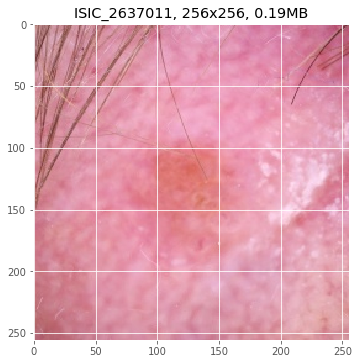

In [ ]:
# testing: render a smaple image
parser = TFRECParser()
parser.load(TFREC_TRAIN_SETS[0][0])
parser.plot_image('ISIC_2637011', show_info=True)

### Testing Random Transformation

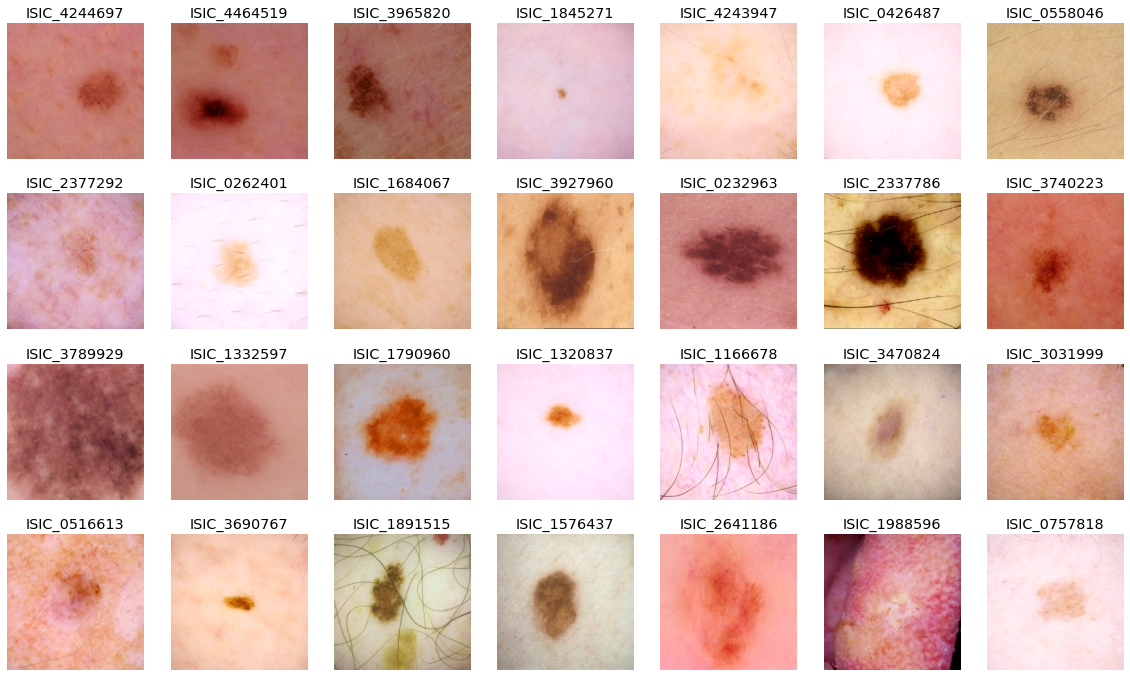

In [ ]:
FOLD_TO_TEST = 0
ds, _ = get_dataset(TFREC_TRAIN_SETS[FOLD_TO_TEST], 
                    augment=True, 
                    shuffle=True, 
                    repeat=True,
                    labeled=False,
                    dim=IMG_SIZES[FOLD_TO_TEST], 
                    batch_size=64)

# plot images
fig, axes = plt.subplots(4, 7, figsize=(20, 12))
images, names = next(iter(ds))
images = images.numpy()
i = 0
for row in axes:
    for ax in row:
        img = images[i] * 255
        img = img.astype(np.uint8)
        img = Image.fromarray(img)
        
        ax.imshow(img)
        ax.set_title(names[i].numpy().decode("utf-8"))
        ax.axis('off')
        i += 1

## Modeling: K-Fold Cross-Validation

### K-Fold Cross-Validation


--------------------------------------------------
FOLD 1
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20
EfficientNetB7, Binary Crossentropy

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.0256 - binary_accuracy: 0.9720 - loss: 0.1789 - auc: 0.6957
Epoch 00001: val_loss improved from inf to 0.16922, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_0.h5
409/409 [==============================] - 155s 378ms/step - recall: 0.0256 - binary_accuracy: 0.9720 - loss: 0.1789 - auc: 0.6957 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.9822 - val_loss: 0.1692 - val_auc: 0.8186
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.0087 - binary_accuracy: 0.9806 - loss: 0.1698 - auc: 0.7770
Epoch 00002: val_loss did not improve from 0.16922
409/409 [==============================] - 139s 340ms/step - recall: 0.0087 - binary_accuracy:

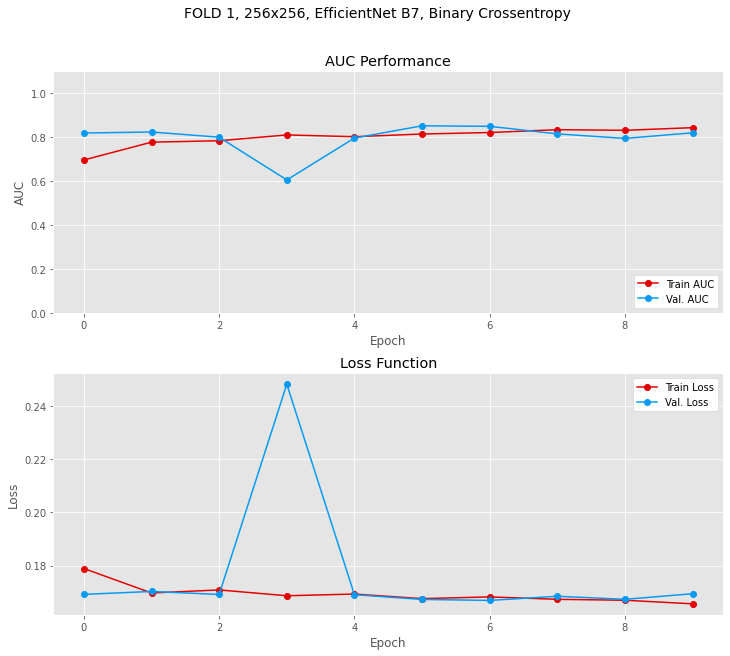


--------------------------------------------------
FOLD 2
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20, FL Alpha 0.75
EfficientNetB7, Focal Loss

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.8043 - binary_accuracy: 0.5047 - loss: 0.0162 - auc: 0.6894
Epoch 00001: val_loss did not improve from inf
409/409 [==============================] - 144s 353ms/step - recall: 0.8043 - binary_accuracy: 0.5047 - loss: 0.0162 - auc: 0.6894 - val_recall: 0.4872 - val_binary_accuracy: 0.3413 - val_loss: inf - val_auc: 0.5157
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.8253 - binary_accuracy: 0.5247 - loss: 0.0138 - auc: 0.7372
Epoch 00002: val_loss improved from inf to 0.01354, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_1.h5
409/409 [==============================] - 129s 316ms/step - recall: 0.8253 - binary_accuracy: 0.52

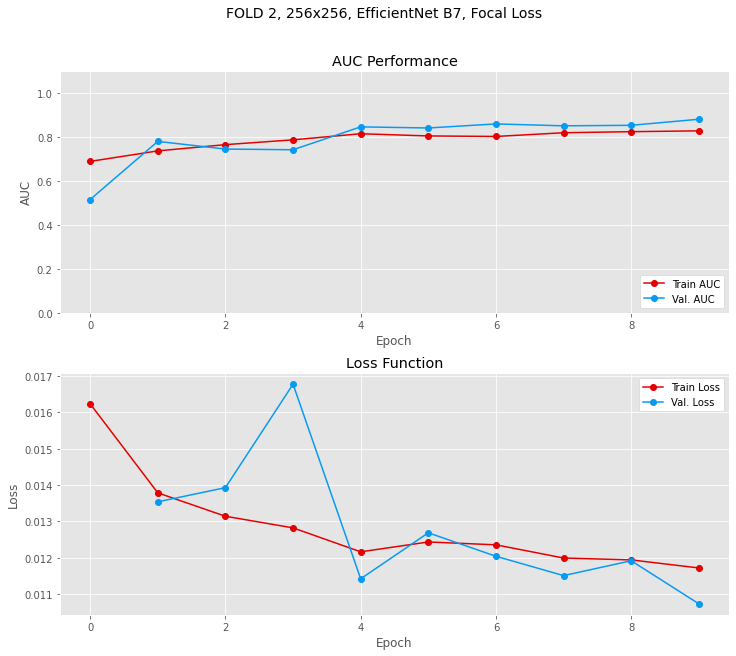


--------------------------------------------------
FOLD 3
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20
EfficientNetB4, Binary Crossentropy

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.0170 - binary_accuracy: 0.9729 - loss: 0.1766 - auc: 0.7294
Epoch 00001: val_loss improved from inf to 0.17066, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_2.h5
409/409 [==============================] - 90s 220ms/step - recall: 0.0170 - binary_accuracy: 0.9729 - loss: 0.1766 - auc: 0.7294 - val_recall: 0.1111 - val_binary_accuracy: 0.9730 - val_loss: 0.1707 - val_auc: 0.8443
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.0237 - binary_accuracy: 0.9807 - loss: 0.1686 - auc: 0.8159
Epoch 00002: val_loss improved from 0.17066 to 0.16759, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/m

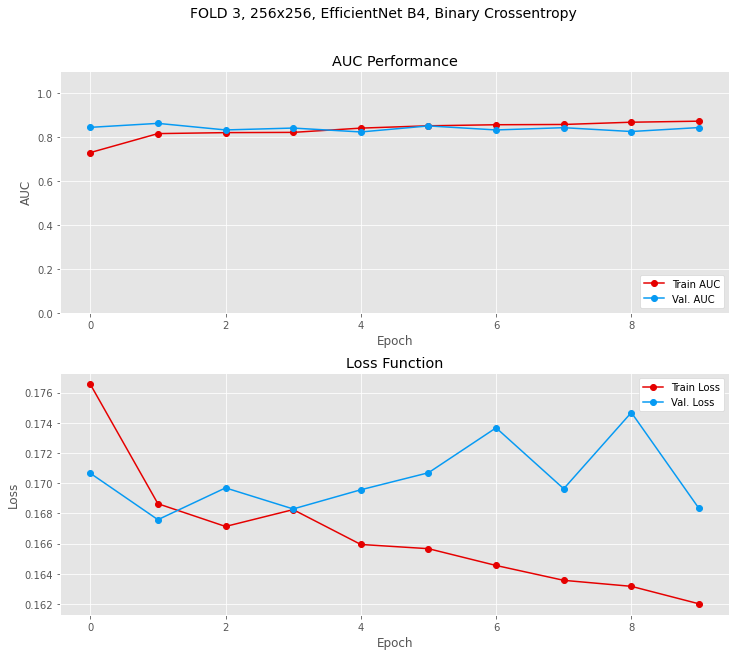


--------------------------------------------------
FOLD 4
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20, FL Alpha 0.75
EfficientNetB4, Focal Loss

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.8333 - binary_accuracy: 0.5118 - loss: 0.0150 - auc: 0.7250
Epoch 00001: val_loss improved from inf to 0.01116, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_3.h5
409/409 [==============================] - 82s 200ms/step - recall: 0.8333 - binary_accuracy: 0.5118 - loss: 0.0150 - auc: 0.7250 - val_recall: 0.9739 - val_binary_accuracy: 0.5599 - val_loss: 0.0112 - val_auc: 0.8590
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.8750 - binary_accuracy: 0.5381 - loss: 0.0130 - auc: 0.7831
Epoch 00002: val_loss did not improve from 0.01116
409/409 [==============================] - 67s 163ms/step - recall: 0.8750 - binary_accuracy:

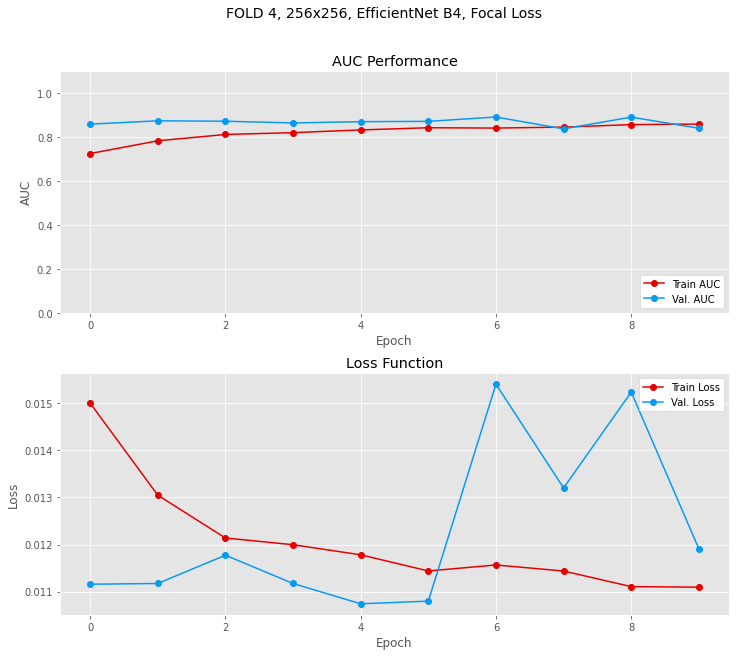


--------------------------------------------------
FOLD 5
--------------------------------------------------
Image Size 256, Batch Size 64, Sigmoid 0.20
EfficientNetB0, Binary Crossentropy

Training...
Epoch 1/10
409/409 [==============================] - ETA: 0s - recall: 0.0213 - binary_accuracy: 0.9725 - loss: 0.1770 - auc: 0.7321
Epoch 00001: val_loss improved from inf to 0.17792, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_233219/model_fold_4.h5
409/409 [==============================] - 50s 122ms/step - recall: 0.0213 - binary_accuracy: 0.9725 - loss: 0.1770 - auc: 0.7321 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.9795 - val_loss: 0.1779 - val_auc: 0.6269
Epoch 2/10
409/409 [==============================] - ETA: 0s - recall: 0.0383 - binary_accuracy: 0.9804 - loss: 0.1700 - auc: 0.7952
Epoch 00002: val_loss improved from 0.17792 to 0.16706, saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/kcv_utc_0720_2332

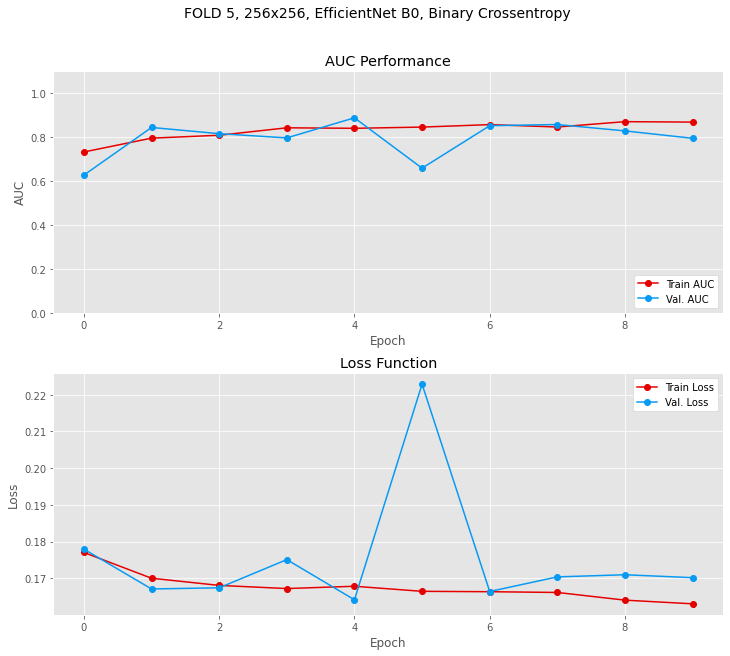

In [ ]:
SAVE_DIR = REPO_ROOT + 'src/neural_network/_saves/cnn_efn/'

# create folder for saving best models
save_dir = ''
if BEST_MODEL:
    st = datetime.utcnow().strftime('kcv_utc_%m%d_%H%M%S')
    save_dir = SAVE_DIR + st
    os.mkdir(save_dir)
    save_dir += '/'

# lists to save img preds
oof_folds = [] 
oof_pred_proba = []
oof_targets = []
oof_img_names = []
oof_loss_functions = []

# lists to save model info
m_folds = []
m_auc_tta = [] # validation auc with tta
m_auc_no_tta = []
m_sigmoid_thd = []
m_acc = [] # validation accuracy
m_recalls = []
m_loss = []

# build & execute k-folds
skf = KFold(n_splits=FOLDS,
            shuffle=True,
            random_state=SEED)
folds = skf.split(np.arange(TFREC_SPLITS)) 
for fold, (i_train, i_valid) in enumerate(folds):
    # print fold info
    print('')
    print('-' * 50)
    print('FOLD', fold + 1)
    print('-' * 50)
    if LOSS_FUNCTIONS[fold] == 1:
        print('Image Size {}, Batch Size {}, Sigmoid {:.2f}, FL Alpha {:.2f}'.format(IMG_SIZES[fold],
                                                                                    BATCH_SIZES[fold],
                                                                                    SIGMOID_THD,
                                                                                    FL_ALPHA))
    else:
        print('Image Size {}, Batch Size {}, Sigmoid {:.2f}'.format(IMG_SIZES[fold],
                                                                    BATCH_SIZES[fold],
                                                                    SIGMOID_THD))
    print('EfficientNetB{}, {}'.format(EFF_NETS[fold],
                                       LOSS_FUNC_NAMES[LOSS_FUNCTIONS[fold]]))
    
    # --------------------------------------------------------------------------
    # BUILD DATASETS

    # get train tfrec files
    files = TFREC_TRAIN_SETS[fold]
    files_train = [files[i] for i in i_train]
    np.random.shuffle(files_train)
    files_valid = [files[i] for i in i_valid]
    
    # --------------------------------------------------------------------------
    # BUILD MODEL
    
    # clear current TF graph to prevent memory leak
    K.clear_session() 
    # use TPU if possible: https://tinyurl.com/y7pkqrat
    with strategy.scope():
        model = build_efns(dim=IMG_SIZES[fold], 
                           ef=EFF_NETS[fold],
                           loss=LOSS_FUNCTIONS[fold])
    
    # save best model
    callbacks = []
    cb = keras.callbacks.ModelCheckpoint(save_dir + 'model_fold_{}.h5'.format(fold), 
                                         monitor='val_loss', 
                                         verbose=1, 
                                         save_best_only=BEST_MODEL,
                                         save_weights_only=True, 
                                         mode='min', 
                                         save_freq='epoch')
    callbacks.append(cb)

    # --------------------------------------------------------------------------
    # TRAINING
    
    print('\nTraining...')

    # this is an ugly fix to the bug on focal loss and the fact that you cannot run
    # gradient norm clipping on distributed strategy
    # https://tinyurl.com/y5ojf9tb
    drop_remainder = False
    if LOSS_FUNCTIONS[fold] == 1:
        drop_remainder = True
    
    ds_train, steps_train = get_dataset(files_train, 
                                        augment=RANDOM_AUG, 
                                        shuffle=True, 
                                        repeat=True,
                                        dim=IMG_SIZES[fold], 
                                        batch_size=BATCH_SIZES[fold],
                                        drop_remainder=drop_remainder)
    ds_valid, steps_valid = get_dataset(files_valid,
                                        augment=False,
                                        shuffle=False,
                                        repeat=False,
                                        dim=IMG_SIZES[fold],
                                        batch_size=BATCH_SIZES[fold],
                                        drop_remainder=drop_remainder)
    history = model.fit(ds_train, 
                        epochs=EPOCHS[fold], 
                        callbacks=callbacks, 
                        steps_per_epoch=steps_train,
                        validation_data=ds_valid, 
                        verbose=1)

    print('\nLoading best model...')
    model.load_weights(save_dir + 'model_fold_{}.h5'.format(fold))
    
    # --------------------------------------------------------------------------
    # PREDICTIONS
        
    print('\nPredicting OOF with TTA...')
    # perform TTA
    ds_valid, steps_valid = get_dataset(files_valid,
                                        labeled=False,
                                        return_img_names=False,
                                        augment=RANDOM_AUG,
                                        repeat=True,
                                        shuffle=False,
                                        dim=IMG_SIZES[fold],
                                        batch_size=BATCH_SIZES[fold])

    if RANDOM_AUG:
        steps_valid = TTA_STEPS * steps_valid
    preds = model.predict(ds_valid,
                          steps=steps_valid,
                          verbose=1)

    # cut off the "reminders" in the last batch 
    ct_valid = count_examples(files_valid)
    if RANDOM_AUG:
        preds = preds[:TTA_STEPS * ct_valid,] 
    else:
        preds = preds[:ct_valid,] 

    # get oof probabilities; avg pred. proba. over TTAs
    preds_reshape = preds
    if RANDOM_AUG:
        # reshape: each column is one round of prediction
        preds_reshape = preds_reshape.reshape((ct_valid, TTA_STEPS), order='F')
    preds_avg = np.mean(preds_reshape, axis=1)

    # get oof targets
    ds_targets, _ = get_dataset(files_valid, 
                                augment=False, 
                                repeat=False, 
                                labeled=True, 
                                dim=IMG_SIZES[fold])
    targets = [target.numpy() for img, target in iter(ds_targets.unbatch())]
    targets = np.array(targets)

    # get oof fold, img names, and loss functions
    ds_img_names, _ = get_dataset(files_valid, 
                                  augment=False, 
                                  repeat=False,
                                  labeled=False, 
                                  return_img_names=True,
                                  dim=IMG_SIZES[fold])
    img_name_arr = np.array([name.numpy().decode("utf-8") for _, name in iter(ds_img_names.unbatch())])
    fold_arr = np.zeros_like(targets, dtype='int8') + fold
    loss_arr = np.empty_like(targets, dtype='U')
    loss_func_name = LOSS_FUNC_NAMES[LOSS_FUNCTIONS[fold]]
    loss_arr = np.char.add(loss_arr, loss_func_name)

    # print oof auc
    auc_tta = roc_auc_score(targets, preds_avg)
    auc_no_tta = np.max(history.history['val_auc'][-1])
    print('FOLD {}:'.format(fold + 1))
    print('OOF AUC without TTA =', auc_no_tta)
    print('OOF AUC with TTA =', auc_tta)

    # print report
    pred_labels = np.zeros(preds_avg.shape[0])
    pred_labels[preds_avg >= SIGMOID_THD] = 1
    report = classification_report(targets, pred_labels, output_dict=True)
    print(classification_report(targets, pred_labels))

    # save img-level pred results
    oof_folds.append(fold_arr)
    oof_img_names.append(img_name_arr)
    oof_targets.append(targets)
    oof_pred_proba.append(preds_avg)
    oof_loss_functions.append(loss_arr)

    # save model info
    m_folds.append(fold)
    m_auc_tta.append(auc_tta)
    m_auc_no_tta.append(auc_no_tta)
    m_sigmoid_thd.append(SIGMOID_THD)
    m_acc.append(report['accuracy'])
    m_recalls.append(report['1']['recall'])
    m_loss.append(loss_func_name)

    # --------------------------------------------------------------------------
    # PLOT PERFORMANCE

    # plot performance metrics
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    fig.suptitle('FOLD {}, {}x{}, EfficientNet B{}, {}'.format(fold + 1,
                                                            IMG_SIZES[fold],
                                                            IMG_SIZES[fold],
                                                            EFF_NETS[fold],
                                                            LOSS_FUNC_NAMES[LOSS_FUNCTIONS[fold]]),
                fontsize=14,
                y=0.97)
    fig.subplots_adjust(hspace=.25)


    # plot AUC
    axes[0].plot(np.arange(EPOCHS[fold]),
            history.history['auc'],
            linestyle='solid',
            marker='o',
            label='Train AUC',
            color='xkcd:red')
    axes[0].plot(np.arange(EPOCHS[fold]),
            history.history['val_auc'],
            linestyle='solid',
            marker='o',
            label='Val. AUC',
            color='xkcd:azure')
    axes[0].set_title('AUC Performance')
    axes[0].set_ylabel('AUC')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylim(top=1.1, bottom=0)
    axes[0].legend(loc=4, 
                frameon=True, 
                framealpha=1, 
                fancybox=True, 
                facecolor='white')

    # plot loss function
    axes[1].plot(np.arange(EPOCHS[fold]),
            history.history['loss'],
            linestyle='solid',
            marker='o',
            label='Train Loss',
            color='xkcd:red')
    axes[1].plot(np.arange(EPOCHS[fold]),
            history.history['val_loss'],
            linestyle='solid',
            marker='o',
            label='Val. Loss',
            color='xkcd:azure')
    axes[1].set_title('Loss Function')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc=1, 
                frameon=True, 
                framealpha=1, 
                fancybox=True, 
                facecolor='white')
    plt.show()
    pass

### Testing Different Sigmoid Thresholds 

In [ ]:
THDS = [0.1, 0.2, 0.5]

for thd in THDS:
    pred_labels = np.zeros(preds_avg.shape[0])
    pred_labels[preds_avg >= thd] = 1
    report = classification_report(targets, pred_labels, output_dict=True)
    print("\nSigmoid THD = {:.2f}:".format(thd))
    print(classification_report(targets, pred_labels))


Sigmoid THD = 0.10:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      6424
           1       0.17      0.37      0.23       115

    accuracy                           0.96      6539
   macro avg       0.58      0.67      0.61      6539
weighted avg       0.97      0.96      0.97      6539


Sigmoid THD = 0.20:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6424
           1       0.54      0.11      0.19       115

    accuracy                           0.98      6539
   macro avg       0.76      0.56      0.59      6539
weighted avg       0.98      0.98      0.98      6539


Sigmoid THD = 0.50:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6424
           1       0.00      0.00      0.00       115

    accuracy                           0.98      6539
   macro avg       0.49      0.50      0.50      6539
weighted av

### Saving K-Fold Cross-Validation Results

In [ ]:
SAVE_DIR_OOF = save_dir
SAVE_DIR_MODEL = REPO_ROOT + 'src/neural_network/_saves/cnn_efn/'

preds = np.concatenate(oof_pred_proba) 
targets = np.concatenate(oof_targets)
names = np.concatenate(oof_img_names)
folds = np.concatenate(oof_folds)
loss = np.concatenate(oof_loss_functions)

auc = roc_auc_score(targets, preds)
print('Overall OOF AUC with TTA = %.3f'%auc)

# save oof results
df_oof = pd.DataFrame(dict(image=names, 
                           target=targets, 
                           prediction=preds, 
                           fold=folds,
                           loss_function=loss))
df_oof.to_csv(SAVE_DIR_OOF + 'oof.csv', index=False)
print('\nOOF:')
display(df_oof.head())

# save models
df_models = pd.DataFrame(dict(fold=m_folds,
                              auc_tta=m_auc_tta,
                              auc_no_tta=m_auc_no_tta,
                              sigmoid_thd=m_sigmoid_thd,
                              accuracy=m_acc,
                              recalls=m_recalls,
                              loss_function=m_loss))
df_models.to_csv(SAVE_DIR_OOF + 'best_models.csv', index=False)
print('\nBest Models:')
display(df_models)

# append model info to global log
st = datetime.utcnow().strftime('utc_%m%d_%H%M%S')
df_models = pd.DataFrame(dict(fold=m_folds,
                              auc_tta=m_auc_tta,
                              auc_no_tta=m_auc_no_tta,
                              sigmoid_thd=m_sigmoid_thd,
                              accuracy=m_acc,
                              recalls=m_recalls,
                              loss_function=m_loss,
                              save_time=st))

global_model_log = SAVE_DIR_MODEL + 'best_models.csv'
include_header = not os.path.isfile(global_model_log)
df_models.to_csv(global_model_log, 
                 index=False, 
                 mode='a',
                 header=include_header)

Overall OOF AUC with TTA = 0.751

OOF:


,image,target,prediction,fold,loss_function
0,ISIC_0077735,0,0.028678,0,Binary Crossentropy
1,ISIC_0099474,0,0.030259,0,Binary Crossentropy
2,ISIC_0079038,0,0.029155,0,Binary Crossentropy
3,ISIC_0090279,0,0.029873,0,Binary Crossentropy
4,ISIC_0148465,0,0.026260,0,Binary Crossentropy



Best Models:


,fold,auc_tta,auc_no_tta,sigmoid_thd,accuracy,recalls,loss_function
0,0,0.852289,0.819504,0.2,0.978091,0.094828,Binary Crossentropy
1,1,0.878429,0.881257,0.2,0.696584,0.923077,Focal Loss
2,2,0.861925,0.843392,0.2,0.974801,0.136752,Binary Crossentropy
3,3,0.874758,0.840267,0.2,0.590777,0.948276,Focal Loss
4,4,0.899668,0.794515,0.2,0.982719,0.113043,Binary Crossentropy


## Predicting Test Dataset

### Full-Dataset Model Training

In [ ]:
BATCH_SIZE = 64
EPOCH = 7
IMG_SIZE = 256 # 128, 192, 256, 384, 512, 768, 1024

LOSS_FUNC = 1
EFF_NET = 7

RANDOM_AUG = False
SIGMOID_THD = 0.2
SAVE_WEIGHTS_ONLY = True
FL_ALPHA = 0.75

SAVE_DIR = REPO_ROOT + 'src/neural_network/_saves/cnn_efn/'
if IS_LOCAL:
    TFREC_TRAIN_SET = tf.io.gfile.glob(TFREC_DIR.format(IMG_SIZE) + 'train*.tfrec')
else:
    TFREC_TRAIN_SET = tf.io.gfile.glob(TFREC_GCS[IMG_SIZE] + '/train*.tfrec')

# --------------------------------------------------------------------------
# BUILD MODEL

print('Building model...')
K.clear_session() 
with strategy.scope():
    model = build_efns(dim=IMG_SIZE, 
                       ef=EFF_NET,
                       loss=LOSS_FUNC,
                       fl_alpha=FL_ALPHA)

# create save dir
st = datetime.utcnow().strftime('fm_utc_%m%d_%H%M%S')
save_dir = SAVE_DIR + st
os.mkdir(save_dir)
save_dir += '/'

# create checkpoints
cb = keras.callbacks.ModelCheckpoint(save_dir + 'model.h5', 
                                     verbose=1, 
                                     save_weights_only=SAVE_WEIGHTS_ONLY, 
                                     save_freq='epoch')
callbacks = [cb]
        
# --------------------------------------------------------------------------
# TRAINING

print('Training...')
ds_train, steps_train = get_dataset(TFREC_TRAIN_SET, 
                                    augment=RANDOM_AUG, 
                                    shuffle=True, 
                                    repeat=True,
                                    dim=IMG_SIZE, 
                                    batch_size=BATCH_SIZE)
history = model.fit(ds_train, 
                    epochs=EPOCH, 
                    callbacks=callbacks, 
                    steps_per_epoch=steps_train,
                    verbose=1)

Building model...
258441216/258434480 [==============================] - 4s 0us/step
Training...
Epoch 1/7
511/511 [==============================] - ETA: 0s - binary_accuracy: 0.5183 - auc: 0.7104 - loss: 0.0154 - recall: 0.7928
Epoch 00001: saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/fm_utc_0723_183646/model.h5
511/511 [==============================] - 147s 287ms/step - binary_accuracy: 0.5183 - auc: 0.7104 - loss: 0.0154 - recall: 0.7928
Epoch 2/7
511/511 [==============================] - ETA: 0s - binary_accuracy: 0.5484 - auc: 0.7548 - loss: 0.0136 - recall: 0.8299
Epoch 00002: saving model to /content/gdrive/My Drive/melanoma/tim/cnn/_saves/cnn_efn/fm_utc_0723_183646/model.h5
511/511 [==============================] - 149s 291ms/step - binary_accuracy: 0.5484 - auc: 0.7548 - loss: 0.0136 - recall: 0.8299
Epoch 3/7
511/511 [==============================] - ETA: 0s - binary_accuracy: 0.5812 - auc: 0.8086 - loss: 0.0124 - recall: 0.8774
Epoch 00003: s

### Final Prediction & Kaggle Submission

In [ ]:
LOAD_MODEL = True

# 128, 192, 256, 384, 512, 768, 1024
TEST_IMG_DIM = 256
BATCH_SIZE = 64
MODEL_H5 = REPO_ROOT + 'src/neural_network/_saves/submissions/submitted/fm_utc_0718_083004/last_model.h5'

SAVE_DIR_SUBMISSION = REPO_ROOT + 'src/neural_network/_saves/submissions/'
if IS_LOCAL:
    TFREC_TEST_SET = tf.io.gfile.glob(TFREC_DIR.format(TEST_IMG_DIM) + 'test*.tfrec')
else:
    TFREC_TEST_SET = tf.io.gfile.glob(TFREC_GCS[TEST_IMG_DIM] + '/test*.tfrec')

# ------------------------------------------------------------------------------
# PREDICTION

# load model
if LOAD_MODEL:
    print('Loading saved model...')
    K.clear_session() 
    with strategy.scope():
        model = keras.models.load_model(MODEL_H5,
                                           custom_objects={'focal_loss_fixed': focal_loss(alpha=0.75, gamma=2)})

# predict test dataset
ds_test, steps = get_dataset(TFREC_TEST_SET,
                             labeled=False,
                             return_img_names=False,
                             augment=RANDOM_AUG,
                             repeat=True,
                             shuffle=False,
                             dim=TEST_IMG_DIM,
                             batch_size=BATCH_SIZE)
if RANDOM_AUG:
    steps = TTA_STEPS * steps
preds = model.predict(ds_test, steps=steps, verbose=1)

# cut off the "reminders" in the last batch 
ct_test = count_examples(TFREC_TEST_SET)
if RANDOM_AUG:
    preds = preds[:TTA_STEPS * ct_test,] 
else:
    preds = preds[:ct_test,] 

# get oof probabilities; avg pred. proba. over TTAs
preds_reshape = preds
if RANDOM_AUG:
    # reshape: each column is one round of prediction
    preds_reshape = preds_reshape.reshape((ct_test, TTA_STEPS), order='F')
preds_avg = np.mean(preds_reshape, axis=1)

# ------------------------------------------------------------------------------
# GET IMAGE NAMES

ds_img_names, steps = get_dataset(TFREC_TEST_SET,
                                  labeled=False,
                                  return_img_names=True,
                                  augment=RANDOM_AUG,
                                  repeat=False,
                                  shuffle=False,
                                  dim=TEST_IMG_DIM)
img_name_arr = np.array([name.numpy().decode("utf-8") for _, name in iter(ds_img_names.unbatch())])

# ------------------------------------------------------------------------------
# SAVE TO CSV

submission = pd.DataFrame(dict(image_name=img_name_arr, 
                               target=preds_avg))
submission.sort_values('image_name', inplace= True) 
st = datetime.utcnow().strftime('utc_%m%d_%H%M%S')
submission.to_csv(SAVE_DIR_SUBMISSION + 'submission_' + st + '.csv', index=False)
submission.head()

Loading saved model...
1720/1720 [==============================] - 160s 93ms/step


,image_name,target
9905,ISIC_0052060,0.064134
1443,ISIC_0052349,0.033001
3120,ISIC_0058510,0.038070
4870,ISIC_0073313,0.027401
5494,ISIC_0073502,0.099102


## Appendix - Logistic Regression & Support Vector Machine
Two simple models, Logistic Regression and SVM with linear kernel, are built as a baseline. Without efforts on optimizing any hyperparameter (i.e. leaving everything as default), both models easily achieve accuracies above 0.97+. However, recall that there are only 500+ positive examples out of the 33,000+ samples included in the training dataset. One can easily achieve a high accuracy just by predicting all examples to be negative.

Given the imbalance in the dataset, the “real” challenge is to identify positive examples. Unfortunately, neither Logistic nor SVM is able to identify positive examples. In addition, AUC performs poorly, with Logistic achieving merely a 0.5+ (essentially no better than random guessing).


### Logistic Regression
Logistic regression is built using a simple 1-layer convolutional neural network in Keras. Images are flattened immediately after the input layer and fed into a dense layer with Sigmoid activation function. Note that all hyperparameters including regularization and number of training epochs are left either as default or given a best educated guess. The goal is to build a simple barebone Logistic Regression as a baseline prediction.

#### Training LR

In [ ]:
LR_BATCH_SIZE = 64
LR_EPOCH = 10
LR_IMG_DIM = 256 # 128, 192, 256, 384, 512, 768, 1024

LR_DEV_SET_FILE_COUNT = 3
LR_LABEL_SMOOTHING = 0.05

LR_LEARN_RATE = 0.001
LR_SIGMOID_THD = 0.2

# prep datasets
if IS_LOCAL:
    TFREC_TEST_SET = tf.io.gfile.glob(TFREC_DIR.format(LR_IMG_DIM) + 'train*.tfrec')
else:
    TFREC_TRAIN_SET = tf.io.gfile.glob(TFREC_GCS[LR_IMG_DIM] + '/train*.tfrec')
random.shuffle(TFREC_TRAIN_SET)
LR_TFREC_DEV_SET = TFREC_TRAIN_SET[:LR_DEV_SET_FILE_COUNT]
LR_TFREC_TRAIN_SET = TFREC_TRAIN_SET[LR_DEV_SET_FILE_COUNT:]

In [ ]:
def build_logistic(dim: int, 
                    sig_thd: float = 0.5,
                    lr: float = 0.001,
                    label_smoothing: float = 0.05) -> Sequential:

    loss_func = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
    
    m = Sequential()
    m.add(InputLayer(input_shape=(dim, dim, 3)))
    m.add(Flatten())
    m.add(Dense(1, activation='sigmoid')) 
    
    # compile model
    m.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=loss_func, 
              metrics=[AUC(),
                       BinaryAccuracy(threshold=sig_thd),
                       Recall(thresholds=sig_thd)])
    return m

In [ ]:
print('Building model...')
keras.backend.clear_session() 
with strategy.scope():
    model = build_logistic(dim=LR_IMG_DIM,
                           sig_thd=LR_SIGMOID_THD,
                           lr=LR_LEARN_RATE,
                           label_smoothing=LR_LABEL_SMOOTHING)
    
print('Training...')
ds_train, steps_train = get_dataset(LR_TFREC_TRAIN_SET, 
                                    augment=False, 
                                    shuffle=True, 
                                    repeat=True,
                                    dim=LR_IMG_DIM, 
                                    batch_size=LR_BATCH_SIZE)
history = model.fit(ds_train, 
                    epochs=LR_EPOCH, 
                    steps_per_epoch=steps_train,
                    verbose=1)

Building model...
Training...
Epoch 1/10
409/409 [==============================] - 8s 21ms/step - binary_accuracy: 0.9393 - loss: 6.1559 - auc: 0.5094 - recall: 0.0541
Epoch 2/10
409/409 [==============================] - 8s 20ms/step - binary_accuracy: 0.9375 - loss: 5.3089 - auc: 0.5141 - recall: 0.0664
Epoch 3/10
409/409 [==============================] - 8s 20ms/step - binary_accuracy: 0.9409 - loss: 5.0507 - auc: 0.5231 - recall: 0.0687
Epoch 4/10
409/409 [==============================] - 7s 18ms/step - binary_accuracy: 0.9401 - loss: 5.7372 - auc: 0.5172 - recall: 0.0675
Epoch 5/10
409/409 [==============================] - 7s 17ms/step - binary_accuracy: 0.9374 - loss: 4.9483 - auc: 0.5160 - recall: 0.0489
Epoch 6/10
409/409 [==============================] - 8s 19ms/step - binary_accuracy: 0.9373 - loss: 5.2167 - auc: 0.5051 - recall: 0.0664
Epoch 7/10
409/409 [==============================] - 8s 19ms/step - binary_accuracy: 0.9415 - loss: 5.4157 - auc: 0.5208 - recall: 0.08

#### LR Predictions

In [ ]:
print('\nPredicting...')
# perform TTA
ds_valid, steps_valid = get_dataset(LR_TFREC_DEV_SET,
                                    labeled=False,
                                    return_img_names=False,
                                    augment=False,
                                    repeat=True,
                                    shuffle=False,
                                    dim=LR_IMG_DIM,
                                    batch_size=LR_BATCH_SIZE)

preds = model.predict(ds_valid,
                        steps=steps_valid,
                        verbose=1)

# cut off the "reminders" in the last batch 
ct_valid = count_examples(LR_TFREC_DEV_SET)
preds = preds[:ct_valid,] 

# get oof probabilities
preds_reshape = preds
preds_avg = np.mean(preds_reshape, axis=1)

# get oof targets
ds_targets, _ = get_dataset(LR_TFREC_DEV_SET, 
                            augment=False, 
                            repeat=False, 
                            labeled=True, 
                            dim=LR_IMG_DIM,
                            batch_size=LR_BATCH_SIZE)
targets = [target.numpy() for img, target in iter(ds_targets.unbatch())]
targets = np.array(targets)

# print oof auc
auc_no_tta = np.max(history.history['auc'])
print('AUC =', auc_no_tta)

# print report
pred_labels = np.zeros(preds_avg.shape[0])
pred_labels[preds_avg >= LR_SIGMOID_THD] = 1
report = classification_report(targets, pred_labels, output_dict=True)
print(classification_report(targets, pred_labels))


Predicting...
103/103 [==============================] - 1s 12ms/step
AUC = 0.5230865478515625
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6441
           1       0.00      0.00      0.00       117

    accuracy                           0.98      6558
   macro avg       0.49      0.50      0.50      6558
weighted avg       0.96      0.98      0.97      6558



#### Testing Different Sigmoid Thresholds

In [ ]:
THDS = [0.1, 0.2, 0.5]
for thd in THDS:
    pred_labels = np.zeros(preds_avg.shape[0])
    pred_labels[preds_avg >= thd] = 1
    report = classification_report(targets, pred_labels, output_dict=True)
    print("\nSigmoid THD = {:.2f}:".format(thd))
    print(classification_report(targets, pred_labels))


Sigmoid THD = 0.10:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6441
           1       0.00      0.00      0.00       117

    accuracy                           0.98      6558
   macro avg       0.49      0.50      0.50      6558
weighted avg       0.96      0.98      0.97      6558


Sigmoid THD = 0.20:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6441
           1       0.00      0.00      0.00       117

    accuracy                           0.98      6558
   macro avg       0.49      0.50      0.50      6558
weighted avg       0.96      0.98      0.97      6558


Sigmoid THD = 0.50:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6441
           1       0.00      0.00      0.00       117

    accuracy                           0.98      6558
   macro avg       0.49      0.50      0.50      6558
weighted av

### Support Vector Machine
A simple SVM with linear kernel is built on sklearn's  `SGDClassifier` (which enables the capability to process a large number of samples using stochastic gradient descent). Note that all hyperparameters including regularization are left either as default or given a best educated guess. The goal is to build a simple barebone SVM as a baseline.

Also note that the dimension of the training images for SVM is set to 128 instead of 256. The choice is solely based on brute-force experimentation. Images of 128x128 consistently outperforms 256x256 in all performance metrics including accuracy (~0.95 vs. ~0.60).


#### Training SVM

In [ ]:
SVM_IMG_DIM = 128
SVM_TRAIN_BATCH_SIZE = 1024
SVM_SCALAR_BATCH_SIZE = 1024 * 5
SVM_PRED_BATCH_SIZE = 1024
SVM_MAX_LOOP = -1 # set to -1 for looping till the end of the dataset
SVM_DEV_SET_FILE_COUNT = 3 # there is a total of 15 TFrecord files

if IS_LOCAL:
    TFREC_TRAIN_SET = tf.io.gfile.glob(TFREC_DIR.format(SVM_IMG_DIM) + 'train*.tfrec')
else:
    TFREC_TRAIN_SET = tf.io.gfile.glob(TFREC_GCS[SVM_IMG_DIM] + '/train*.tfrec')
random.shuffle(TFREC_TRAIN_SET)
SVM_TFREC_DEV_SET = TFREC_TRAIN_SET[:SVM_DEV_SET_FILE_COUNT]
SVM_TFREC_TRAIN_SET = TFREC_TRAIN_SET[SVM_DEV_SET_FILE_COUNT:]

In [ ]:
def get_svm_batch_iterator(dataset: list,
                           batch_size: int = 1024,
                           img_dim: int = 128) -> iter:
    """Return an images & targets iterator. 
        [0]: Images in np.ndarray
        [1]: Targets (0 or 1) in an 1D np.ndarray
    """
    ds, _ = get_dataset(dataset,
                        shuffle=False,
                        augment=False, 
                        repeat=False, 
                        labeled=True, 
                        dim=img_dim, 
                        batch_size=batch_size)
    return ds.as_numpy_iterator()

def flatten_img_arr(images: np.ndarray) -> np.ndarray:
    """Flatten all image ndarray included in the argument `images`.
    """
    n = images.shape[1] * images.shape[2] * images.shape[3] # n = total num of pixels * num of channels
    return images.reshape([-1, n])

In [ ]:
# scaler transformation, as required for SVM
print('Scaler transformation begins...')
iterator = get_svm_batch_iterator(SVM_TFREC_TRAIN_SET, 
                                  SVM_SCALAR_BATCH_SIZE,
                                  SVM_IMG_DIM)
scaler = StandardScaler()
i = 0
img_count = 0
while True:
    try:
        # transform
        images, _ = next(iterator)
        images = flatten_img_arr(images)
        scaler.partial_fit(images)

        # print status
        img_count += images.shape[0]
        print('{:,d} images transformed...'.format(img_count))
    except:
        print('Scaler transformation complete!')
        break

# training SVM
print('\nSVM training begins...')
clf_svm = SGDClassifier(warm_start=True)
iterator = get_svm_batch_iterator(SVM_TFREC_TRAIN_SET, 
                                  SVM_TRAIN_BATCH_SIZE,
                                  SVM_IMG_DIM)
i = SVM_MAX_LOOP if SVM_MAX_LOOP > 0 else float('inf')
j = 0
while i > 0:
    try:
        j += 1
        print(f'Training batch {j}...')

        images, targets = next(iterator)
        images = flatten_img_arr(images)
        images = scaler.transform(images)

        clf_svm.partial_fit(images, targets, [0, 1])

        i -= 1
    except:
        print('All data available have been served!')
        break

Scaler transformation begins...
5,120 images transformed...
10,240 images transformed...
15,360 images transformed...
20,480 images transformed...
25,600 images transformed...
26,136 images transformed...
Scaler transformation complete!

SVM training begins...
Training batch 1...
Training batch 2...
Training batch 3...
Training batch 4...
Training batch 5...
Training batch 6...
Training batch 7...
Training batch 8...
Training batch 9...
Training batch 10...
Training batch 11...
Training batch 12...
Training batch 13...
Training batch 14...
Training batch 15...
Training batch 16...
Training batch 17...
Training batch 18...
Training batch 19...
Training batch 20...
Training batch 21...
Training batch 22...
Training batch 23...
Training batch 24...
Training batch 25...
Training batch 26...
Training batch 27...
All data available have been served!


#### SVM Predictions

In [ ]:
print('Predicting dev data...')
iterator = get_svm_batch_iterator(SVM_TFREC_DEV_SET,
                                  SVM_PRED_BATCH_SIZE,
                                  SVM_IMG_DIM)
img_count = 0
preds = []
labels = []
for images, targets in iterator:
    # scaler transforma an
    # scaler transforma and predict
    images = flatten_img_arr(images)
    images = scaler.transform(images)
    preds.extend(clf_svm.predict(images))
    labels.extend(targets.tolist())
    
    # print status
    img_count += images.shape[0]
    print('{:,d} images predicted...'.format(img_count))

print('')
print(classification_report(labels, preds))

Predicting dev data...
1,024 images predicted...
2,048 images predicted...
3,072 images predicted...
4,096 images predicted...
5,120 images predicted...
6,144 images predicted...
6,556 images predicted...

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6440
           1       0.07      0.05      0.06       116

    accuracy                           0.97      6556
   macro avg       0.53      0.52      0.52      6556
weighted avg       0.97      0.97      0.97      6556

